# Mandeep Plots

## Initialization

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import galsim

## Josh's Deblender

In [5]:
def deblend(image, peaks, interpolate=False, force_interpolate=False):
    """ Quick and dirty deblender.
    Args
    ----
    @param image        A numpy array representing an image of a blend.
    @param peaks        A list of tuples representing the peak positions of objects in the blend.
    @param interpolate  If at least one component of rot_center is not a half-integer, use GalSim
                        to rotate the image.  This currently doesn't work very well!!!
    @param force_interpolate   Use GalSim to rotate the image, even if rot_center components are
                               half-integer and rotation via numpy array operations is possible.
                               This currently doesn't work very well!!!
    
    @returns templates, template_fractions, children
    
    """
    work_image = image+1.e-20

    # Step 1: Make symmetric templates
    templates = [np.fmin(work_image, rotate(work_image, peak,
                                            interpolate=interpolate,
                                            force_interpolate=force_interpolate))
                 for peak in peaks]

    # Step 2: Calculate relative contribution of each template
    template_sum = np.sum(templates, axis=0)
    template_fractions = [template/template_sum * (template_sum != 0) for template in templates]

    # Step 3: Calculate deblended children
    children = [t * image for t in template_fractions]

    return templates, template_fractions, children

def rotate(image, rot_center, interpolate=False, force_interpolate=False):
    """ Rotate an image about a point.  Defaults to using numpy array operations, which means that
    the rotation center is rounded to the nearest half-pixel grid point.  Optionally, use GalSim to
    rotate about arbitrary positions, which requires interpolation since the rotated pixel grid
    doesn't generally align with the original pixel grid.
    @param image        Image to rotate
    @param rot_center   Tuple indicating point to be rotated about.  (0,0) indicates rotate about
                        the geometric center of the image (so at the corner of 4 pixels if the
                        image is even-sized, or at the center of a single pixel if the image is
                        odd-sized image.
    @param interpolate  If at least one component of rot_center is not a half-integer, use GalSim
                        to rotate the image.  This currently doesn't work very well!!!
    @param force_interpolate   Use GalSim to rotate the image, even if rot_center components are
                               half-integer and rotation via numpy array operations is possible.
                               This currently doesn't work very well!!!
    @returns   Rotated image.
    """
    height, width = image.shape

    # Round rot_center to nearest half-integer
    rrot_center = [0.5*np.rint(2*p) for p in rot_center]

    if force_interpolate or (interpolate and rrot_center != rot_center):
        try:
            import galsim
        except:
            raise ImportError("can't interpolate w/o galsim")
        imobj = (galsim.InterpolatedImage(galsim.ImageD(image, scale=1),
                                          calculate_stepk=False,
                                          calculate_maxk=False)
                 .shift(-rot_center[0], -rot_center[1])
                 .rotate(180*galsim.degrees)
                 .shift(rot_center[0], rot_center[1]))
        return imobj.drawImage(nx=width, ny=height, scale=1, method='no_pixel').array

    # image_center is 0-indexed and measured from the lower-left corner of the lower-left pixel.
    image_center = (width * 0.5, height * 0.5)
    rot_pix_center = (image_center[0] + rrot_center[0],
                      image_center[1] + rrot_center[1])

    # compute boundary of rotate region
    rot_width = 2.0*min(rot_pix_center[0], width-rot_pix_center[0])
    rot_height = 2.0*min(rot_pix_center[1], height-rot_pix_center[1])
    rot_bounds = [0,width,0,height] # xmin, xmax, ymin, ymax

    # handle edges falling outside original postage stamp
    if rot_pix_center[0] <= image_center[0]:
        rot_bounds[1] = rot_pix_center[0] + rot_width/2
    else:
        rot_bounds[0] = rot_pix_center[0] - rot_width/2
    if rot_pix_center[1] <= image_center[1]:
        rot_bounds[3] = rot_pix_center[1] + rot_height/2
    else:
        rot_bounds[2] = rot_pix_center[1] - rot_height/2
    xmin, xmax, ymin, ymax = rot_bounds

    # and finally, rotate!
    newimage = np.zeros_like(image)
    newimage[ymin:ymax, xmin:xmax] = (image[ymin:ymax, xmin:xmax])[::-1,::-1]
    return newimage

## Mandeep's Study

In [6]:
def purities(image1, image2):
    """"
    Returns tuple (rho1, rho2) of the purities of image1 and image2, respectively,
    assuming that they are blended with each other, but otherwise isolated from any
    other galaxies.
    """
    p1, p2 = image1.array.flatten(), image2.array.flatten()
    p12 = p1 + p2
    return p1.dot(p1) / p1.dot(p12), p2.dot(p2) / p2.dot(p12)

In [7]:
def overlap_image(image1, image2):
    return image1 * image2 / (image1 + image2)

In [8]:
def makeplot(pltname, pltcontent,  centre=(0,0) , colorbarlimit = 0, zoom = 2.):

    plt.title(pltname)

    vmin,vmax = np.percentile(pltcontent,[1,99])
    vmax = max(abs(vmin),abs(vmax))
    vmin = -vmax

    ysize, xsize = pltcontent.shape

    pltimg = plt.imshow( pltcontent , origin='lower', interpolation='none', vmin = vmin, vmax=vmax, cmap='seismic')

    x_inset = 0.5 * xsize * (1 - 1. / zoom)
    y_inset = 0.5 * ysize * (1 - 1. / zoom)
    plt.xlim(x_inset, xsize - x_inset)
    plt.ylim(y_inset, ysize - y_inset)

    if colorbarlimit==1:
        pltimg.set_clim(-1,1)
    #plt.colorbar()
    if (centre[0] !=0 and centre[1] !=0):
        plt.plot(centre[0][0], centre[0][1],  'wx')
        plt.plot(centre[1][0], centre[1][1],  'wx')

In [43]:
def create_blend(flux_bTOa, size_bTOa, peak_a=(-1, 0), peak_b=(+1, 0), e1a = 0, e1b = 0 , e2a = 0, e2b = 0,
                 imgsize = 101, pixelscale = 0.2, mrkrsize = 10, plot=True, alpha=0.05, zoom=2.):

    # Global vars
    randnum=galsim.BaseDeviate(1) # Random num seed -- when set to zero, uses machine time

    # Create gaussian gal objs, sheared in various directions
    hlr_a = 1.0
    hlr_b = hlr_a * size_bTOa

    flux_a = 1e4
    flux_b = flux_a * flux_bTOa
    
    gal1 = galsim.Gaussian(half_light_radius= hlr_a , flux= flux_a).shear(g1=e1a, g2= e2a).shift(peak_a)
    gal2 = galsim.Gaussian(half_light_radius= hlr_b , flux= flux_b).shear(g1=e1b, g2= e2b).shift(peak_b)
    
    # Add psf 
    psfshr = 0.00
    psf = galsim.Moffat(beta=3, fwhm=0.85).shear(e1 = psfshr,  e2 = -psfshr)

    convgal1 = galsim.Convolve([gal1,psf])
    convgal2 = galsim.Convolve([gal2,psf])
    
    # Now make imgs
    imgcent = imgsize / 2.

    # Img1
    image1 = galsim.ImageD(imgsize, imgsize, scale = pixelscale)
    image1 = convgal1.drawImage(image=image1)

    # Img2
    image2 = galsim.ImageD(imgsize, imgsize, scale = pixelscale)
    image2 = convgal2.drawImage(image=image2)    

    # Add them into one image
    imagesum =  image1+image2
    
    # Calculate purities of each galaxy.
    rho1, rho2 = purities(image1, image2)
    
    # Calculate the overlap region.
    overlap = overlap_image(image1, image2)
    
    # Run Josh's deblender
    peaks_pix = [[p1 / pixelscale for p1 in peak_a], [p2 / pixelscale for p2 in peak_b]]
    templates, template_fractions, children = deblend(
        imagesum.array, peaks_pix, interpolate=False, force_interpolate=False)
    assert np.allclose(children[0] + children[1], imagesum.array), 'Deblend is not flux conserving!'
    
    if plot:
        acent = (imgcent+peak_a[0]/pixelscale, imgcent+peak_a[1]/pixelscale)
        bcent = (imgcent+peak_b[0]/pixelscale, imgcent+peak_b[1]/pixelscale)
        pixmax = np.max(image1.array)

        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plotval1 = (children[0] - image1.array) / pixmax
        makeplot('Flux b/a = {:.1f}, Size b/a = {:.1f}'.format(flux_bTOa, size_bTOa), plotval1,
                 centre=(acent, bcent), zoom=zoom)
        plt.axhline(50., color='k', ls='-')
          
        plotval2 = alpha * overlap.array / pixmax
            
        '''
        plt.subplot(1, 3, 2)
        
        makeplot('$\\rho$ = {:.3f}, {:.3f}, $\\alpha$ = {:.3f}'.format(rho1, rho2, alpha), plotval2,
                 centre=(acent, bcent), zoom=zoom)
        plt.axhline(50., color='k', ls='--')
        '''
    
        plt.subplot(1, 2, 2)
        plotval3 = plotval1 / plotval2
        xvec = np.linspace(0.5, imgsize - 0.5, imgsize)
        ihalf = (imgsize - 1) // 2
        jzoom = int(round(0.5 * imgsize * (1 - 1. / zoom)))
        plt.fill_between(xvec, 1e-3 * image1.array[ihalf], color='g', alpha=0.25)
        plt.fill_between(xvec, 1e-3 * image2.array[ihalf], color='g', alpha=0.25)
        plt.plot(xvec, plotval1[ihalf], 'k-')
        #plt.plot(xvec, plotval2[ihalf], 'k--')
        #plt.plot(plotval3[ihalf], 'k')
        plt.xlim(jzoom, imgsize - jzoom)
        plt.grid()
        #plt.ylim(-5., +5.)
        plt.ylabel('A and B and A-resid profiles on y=50 midline')
        
        plt.savefig(plot)

    return imagesum, [image1, image2], children

/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


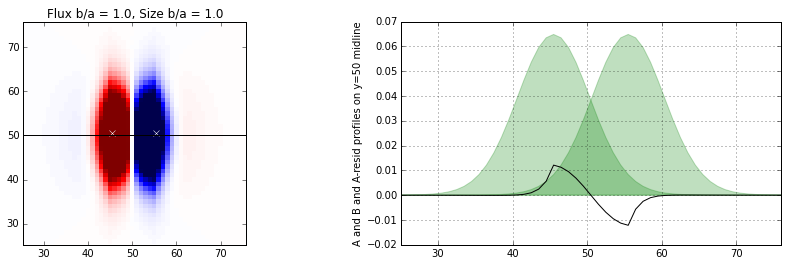

In [44]:
blend, unblends, children = create_blend(flux_bTOa=1.0, size_bTOa=1.0, plot='pair_1.0_1.0.png')

/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


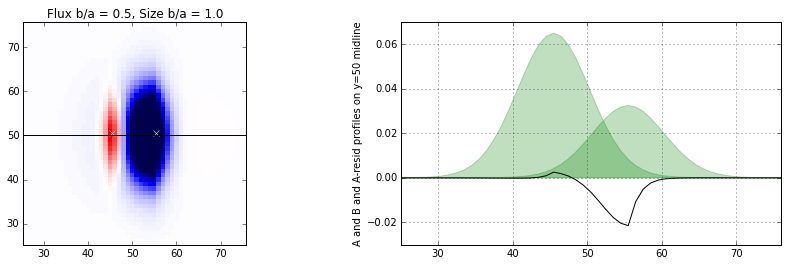

In [45]:
blend, unblends, children = create_blend(flux_bTOa=0.5, size_bTOa=1.0, plot='pair_0.5_1.0.png')

/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


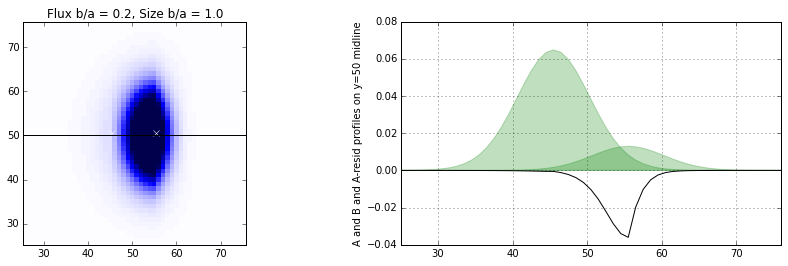

In [46]:
blend, unblends, children = create_blend(flux_bTOa=0.2, size_bTOa=1.0, plot='pair_0.2_1.0.png')

/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


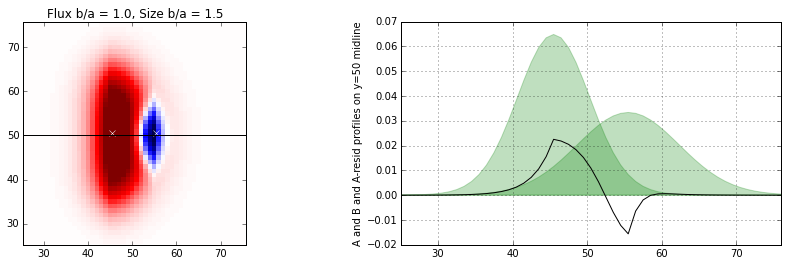

In [47]:
blend, unblends, children = create_blend(flux_bTOa=1.0, size_bTOa=1.5, plot='pair_1.0_1.5.png')

/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


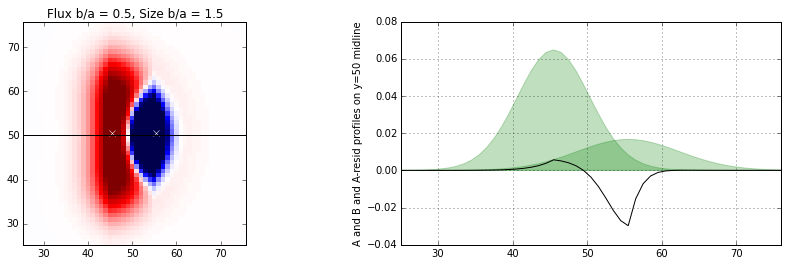

In [48]:
blend, unblends, children = create_blend(flux_bTOa=0.5, size_bTOa=1.5, plot='pair_0.5_1.5.png')

/Users/m/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


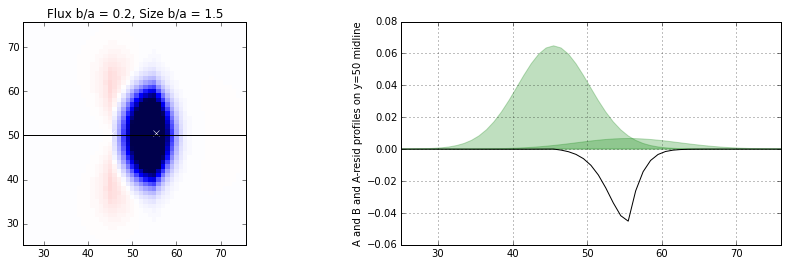

In [49]:
blend, unblends, children = create_blend(flux_bTOa=0.2, size_bTOa=1.5, plot='pair_0.2_1.5.png')

In [14]:
def purity_plot(img1, img2):
    ratios = np.logspace(-1.5, +1.5, 41)
    rho1_vec = np.empty_like(ratios)
    rho2_vec = np.empty_like(ratios)
    for i, r in enumerate(ratios):
        rho1, rho2 = purities(img1, r * img2)
        rho1_vec[i] = rho1
        rho2_vec[i] = rho2
    plt.plot(ratios, rho1_vec, 'b-', label='$\\rho_1$')
    plt.plot(ratios, rho2_vec, 'r--', label='$\\rho_2$')
    plt.legend(loc='lower center')
    plt.xscale('log')
    plt.xlim(ratios[0], ratios[-1])
    plt.xlabel('Flux ratio $f_2 / f_1$')
    plt.ylabel('Purity')
    plt.grid()

/Users/david/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


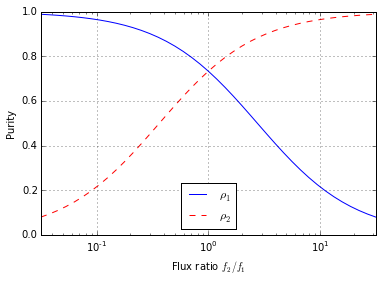

In [15]:
blend, unblends, children = create_blend(flux_bTOa=1.0, size_bTOa=1.0, plot=False)
purity_plot(unblends[0], unblends[1])
plt.savefig('purity_X.X_1.0.png')

/Users/david/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:91: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


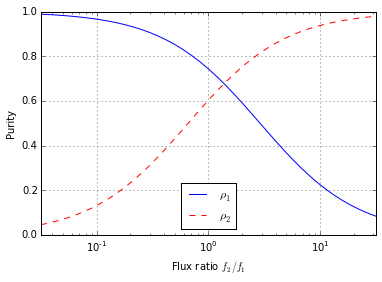

In [16]:
blend, unblends, children = create_blend(flux_bTOa=1.0, size_bTOa=1.5, plot=False)
purity_plot(unblends[0], unblends[1])